# Model Validation Report: Position Changes Prediction Model

##  Model Overview
This report documents the validation of an XGBoost regression model developed to predict **driver position changes** in Formula 1 races based on various driver, race, and strategy factors.

The model was trained using hand-engineered features derived from lap and pit data, weather conditions, and driver characteristics. It was tuned using GridSearchCV and compared against baseline regressors (Random Forest, Linear Regression, etc.), ultimately achieving:

**Best R² Score**: `0.9437` (Tuned XGBoost)

---

## Features Used for Prediction
The trained model uses the following features:

- `AvgPitStopTime`
- `Lap Time Variation`
- `Fast Lap Attempts`
- `Driver Aggression Score`
- `Tire Usage Aggression`
- `Driver`
- `Laps`
- `Pit_Time`
- `Total Pit Stops`

These features were selected based on Mutual Information Scores, correlation heatmaps, and Variance Inflation Factor (VIF) analysis.

---

##  Prediction Validation (Synthetic Test)
To validate the deployed model, a **synthetic dataset** was created with realistic input values. Predictions were generated and evaluated via correlation against the input features.

### Correlation Heatmap Summary:
| Feature                   | Correlation with Predicted Position Changes |
|---------------------------|---------------------------------------------|
| Tire Usage Aggression    | **+0.71**                                    |
| Driver Aggression Score  | **+0.71**                                    |
| Fast Lap Attempts        | **-0.76**                                    |
| AvgPitStopTime           | **-0.59**                                    |
| Laps                     | +0.43                                        |
| Pit_Time                 | +0.27                                        |
| Driver                   | +0.18                                        |
| Total Pit Stops          | +0.16                                        |
| Lap Time Variation       | +0.058                                       |

###  Insight:
The model shows **strong logical consistency**:
- More aggressive drivers or tire use → More position gains.
- More fast laps attempted → Less improvement (possibly due to over-driving).
- Longer pit stops and slower laps correlate with fewer gains.

---

##  Next Step: Deploying a Prediction Dashboard
A web-based **interactive dashboard** will be built next to:
- Input driver and race metrics
- Predict expected position changes
- Visualize feature impacts
- Simulate race strategy scenarios

This dashboard will use the deployed `xgboost_model.pkl` file, and allow real-time interaction for fans, analysts, and team strategists.


---

##  Summary
-  Model predictions validated using synthetic test cases
-  Feature-behavior relationships confirmed
-  Dashboard development next for interactive usage



In [ ]:
import pandas as pd
import requests
import time
from datetime import datetime
import numpy as np
!pip install fastf1
import fastf1
import os
import ast

!os.mkdir("f1_cache")
fastf1.Cache.enable_cache('f1_cache')

pit_stop_file = "/content/drive/MyDrive/Formula1 Data/Formula1_Pitstop_Data_1950-2024_all_rounds.xlsx"
df_pitstops = pd.read_excel(pit_stop_file)
df_pitstops.head()


In [106]:
df_pitstops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26759 entries, 0 to 26758
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          26759 non-null  int64  
 1   Round           26759 non-null  int64  
 2   Circuit         26759 non-null  object 
 3   Driver          26759 non-null  object 
 4   Constructor     26759 non-null  object 
 5   Laps            26759 non-null  int64  
 6   Position        26759 non-null  int64  
 7   TotalPitStops   26759 non-null  int64  
 8   AvgPitStopTime  5575 non-null   float64
 9   PitStops        26759 non-null  object 
dtypes: float64(1), int64(5), object(4)
memory usage: 2.0+ MB


In [107]:
races = df_pitstops[['Season', 'Round', 'Circuit',]].drop_duplicates()

print("Unique races extracted from the dataset:")
print(races.head())

Unique races extracted from the dataset:
    Season  Round                       Circuit
0     1950      1           Silverstone Circuit
23    1950      2             Circuit de Monaco
44    1950      3   Indianapolis Motor Speedway
79    1950      4            Circuit Bremgarten
97    1950      5  Circuit de Spa-Francorchamps


In [108]:
df_schedule = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_pitstop_Date_time_1950_2024.csv")

df_merged = df_pitstops.merge(df_schedule, on=["Season", "Round", "Circuit"], how="left")

df_merged.to_csv("f1_pitstop_with_schedule.csv", index=False)

print(df_merged.head())




   Season  Round              Circuit          Driver  Constructor  Laps  \
0    1950      1  Silverstone Circuit     Nino Farina   Alfa Romeo    70   
1    1950      1  Silverstone Circuit   Luigi Fagioli   Alfa Romeo    70   
2    1950      1  Silverstone Circuit     Reg Parnell   Alfa Romeo    70   
3    1950      1  Silverstone Circuit  Yves Cabantous  Talbot-Lago    68   
4    1950      1  Silverstone Circuit    Louis Rosier  Talbot-Lago    68   

   Position  TotalPitStops  AvgPitStopTime PitStops           Race Name  \
0         1              0             NaN       []  British Grand Prix   
1         2              0             NaN       []  British Grand Prix   
2         3              0             NaN       []  British Grand Prix   
3         4              0             NaN       []  British Grand Prix   
4         5              0             NaN       []  British Grand Prix   

         Date Time (UTC)     Location Country  
0  1950-05-13    Unknown  Silverstone      U

In [109]:
df = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_pitstop_Date_time_1950_2024.csv")
df.head()

,Season,Round,Race Name,Date,Time (UTC),Circuit,Location,Country
0,1950,1,British Grand Prix,1950-05-13,Unknown,Silverstone Circuit,Silverstone,UK
1,1950,2,Monaco Grand Prix,1950-05-21,Unknown,Circuit de Monaco,Monte-Carlo,Monaco
2,1950,3,Indianapolis 500,1950-05-30,Unknown,Indianapolis Motor Speedway,Indianapolis,USA
3,1950,4,Swiss Grand Prix,1950-06-04,Unknown,Circuit Bremgarten,Bern,Switzerland
4,1950,5,Belgian Grand Prix,1950-06-18,Unknown,Circuit de Spa-Francorchamps,Spa,Belgium


In [110]:
df.tail()

,Season,Round,Race Name,Date,Time (UTC),Circuit,Location,Country
1120,2024,20,Mexico City Grand Prix,2024-10-27,20:00:00Z,Autódromo Hermanos Rodríguez,Mexico City,Mexico
1121,2024,21,São Paulo Grand Prix,2024-11-03,17:00:00Z,Autódromo José Carlos Pace,São Paulo,Brazil
1122,2024,22,Las Vegas Grand Prix,2024-11-23,06:00:00Z,Las Vegas Strip Street Circuit,Las Vegas,United States
1123,2024,23,Qatar Grand Prix,2024-12-01,17:00:00Z,Losail International Circuit,Al Daayen,Qatar
1124,2024,24,Abu Dhabi Grand Prix,2024-12-08,13:00:00Z,Yas Marina Circuit,Abu Dhabi,UAE


In [111]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1125 entries, 0 to 1124
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Season      1125 non-null   int64 
 1   Round       1125 non-null   int64 
 2   Race Name   1125 non-null   object
 3   Date        1125 non-null   object
 4   Time (UTC)  1125 non-null   object
 5   Circuit     1125 non-null   object
 6   Location    1125 non-null   object
 7   Country     1125 non-null   object
dtypes: int64(2), object(6)
memory usage: 70.4+ KB


In [112]:
races = df[['Season', 'Round', 'Circuit','Date','Time (UTC)']].drop_duplicates()

print(races.head())
df_unique_races = races
df_unique_races.to_csv("f1_unique_races.csv", index=False)


   Season  Round                       Circuit        Date Time (UTC)
0    1950      1           Silverstone Circuit  1950-05-13    Unknown
1    1950      2             Circuit de Monaco  1950-05-21    Unknown
2    1950      3   Indianapolis Motor Speedway  1950-05-30    Unknown
3    1950      4            Circuit Bremgarten  1950-06-04    Unknown
4    1950      5  Circuit de Spa-Francorchamps  1950-06-18    Unknown


In [113]:
df = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_pitstop_race_weather.csv")
df.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,Race Name,Date,Time (UTC),Location,Country,Air Temperature (°C),Track Temperature (°C),Humidity (%),Wind Speed (km/h)
0,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.319500,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
1,2011,1,Albert Park Grand Prix Circuit,Lewis Hamilton,McLaren,58,2,2,23.213000,"[{'Lap': 16, 'StopTime': 23.227}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
2,2011,1,Albert Park Grand Prix Circuit,Vitaly Petrov,Renault,58,3,2,25.109000,"[{'Lap': 16, 'StopTime': 24.535}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
3,2011,1,Albert Park Grand Prix Circuit,Fernando Alonso,Ferrari,58,4,3,24.055000,"[{'Lap': 12, 'StopTime': 23.251}, {'Lap': 27, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
4,2011,1,Albert Park Grand Prix Circuit,Mark Webber,Red Bull,58,5,3,24.058667,"[{'Lap': 11, 'StopTime': 23.426}, {'Lap': 26, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05


In [114]:
df.tail()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,Race Name,Date,Time (UTC),Location,Country,Air Temperature (°C),Track Temperature (°C),Humidity (%),Wind Speed (km/h)
5712,2024,24,Yas Marina Circuit,Kevin Magnussen,Haas F1 Team,57,16,4,23.2365,"[{'Lap': 12, 'StopTime': 26.363}, {'Lap': 29, ...",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5713,2024,24,Yas Marina Circuit,Liam Lawson,RB F1 Team,55,17,3,26.0990,"[{'Lap': 23, 'StopTime': 23.415}, {'Lap': 24, ...",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5714,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.1440,"[{'Lap': 6, 'StopTime': 41.144}]",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5715,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.9410,"[{'Lap': 3, 'StopTime': 24.941}]",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5716,2024,24,Yas Marina Circuit,Sergio PÃ©rez,Red Bull,0,20,0,NaN,[],Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3


In [115]:
df.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,Race Name,Date,Time (UTC),Location,Country,Air Temperature (°C),Track Temperature (°C),Humidity (%),Wind Speed (km/h)
0,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.319500,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
1,2011,1,Albert Park Grand Prix Circuit,Lewis Hamilton,McLaren,58,2,2,23.213000,"[{'Lap': 16, 'StopTime': 23.227}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
2,2011,1,Albert Park Grand Prix Circuit,Vitaly Petrov,Renault,58,3,2,25.109000,"[{'Lap': 16, 'StopTime': 24.535}, {'Lap': 36, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
3,2011,1,Albert Park Grand Prix Circuit,Fernando Alonso,Ferrari,58,4,3,24.055000,"[{'Lap': 12, 'StopTime': 23.251}, {'Lap': 27, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05
4,2011,1,Albert Park Grand Prix Circuit,Mark Webber,Red Bull,58,5,3,24.058667,"[{'Lap': 11, 'StopTime': 23.426}, {'Lap': 26, ...",Australian Grand Prix,27-03-2011,06:00:00Z,Melbourne,Australia,15.183333,0.0,77.375,6.05


In [116]:
df.tail()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,Race Name,Date,Time (UTC),Location,Country,Air Temperature (°C),Track Temperature (°C),Humidity (%),Wind Speed (km/h)
5712,2024,24,Yas Marina Circuit,Kevin Magnussen,Haas F1 Team,57,16,4,23.2365,"[{'Lap': 12, 'StopTime': 26.363}, {'Lap': 29, ...",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5713,2024,24,Yas Marina Circuit,Liam Lawson,RB F1 Team,55,17,3,26.0990,"[{'Lap': 23, 'StopTime': 23.415}, {'Lap': 24, ...",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5714,2024,24,Yas Marina Circuit,Valtteri Bottas,Sauber,30,18,1,41.1440,"[{'Lap': 6, 'StopTime': 41.144}]",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5715,2024,24,Yas Marina Circuit,Franco Colapinto,Williams,26,19,1,24.9410,"[{'Lap': 3, 'StopTime': 24.941}]",Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3
5716,2024,24,Yas Marina Circuit,Sergio PÃ©rez,Red Bull,0,20,0,NaN,[],Abu Dhabi Grand Prix,08-12-2024,13:00:00Z,Abu Dhabi,UAE,24.4625,0.0,55.041667,9.3


In [117]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Season                  5717 non-null   int64  
 1   Round                   5717 non-null   int64  
 2   Circuit                 5717 non-null   object 
 3   Driver                  5717 non-null   object 
 4   Constructor             5717 non-null   object 
 5   Laps                    5717 non-null   int64  
 6   Position                5717 non-null   int64  
 7   TotalPitStops           5717 non-null   int64  
 8   AvgPitStopTime          5329 non-null   float64
 9   PitStops                5717 non-null   object 
 10  Race Name               5422 non-null   object 
 11  Date                    5422 non-null   object 
 12  Time (UTC)              5422 non-null   object 
 13  Location                5422 non-null   object 
 14  Country                 5422 non-null   

In [118]:
def estimate_track_temp(row):
    if row["Humidity (%)"] < 60:
        solar_factor = 15
    elif row["Humidity (%)"] < 80:
        solar_factor = 5
    else:
        solar_factor = 2

    return row["Air Temperature (°C)"] + (5 + 0.1 * solar_factor)


df["Track Temperature (°C)"] = df.apply(estimate_track_temp, axis=1)


df.to_csv("f1_weather_with_estimated_track_temp.csv", index=False)

print("Track temperature estimated and saved successfully!")


Track temperature estimated and saved successfully!


#Computing a Driver Aggression Score
We can create a Driver Aggression Index (DAI) using a weighted combination of these factors.

###Step 1: Normalize Key Metrics
First, normalize each metric between 0 and 1 so they are comparable.

###Step 2: Assign Weights Based on Importance
Not all metrics contribute equally. Assign higher weight to lap time variation and pit stops.

###Step 3: Compute Driver Aggression Index (DAI)
**DAI
=
𝑤
1
(
Lap Time Variation
)
+
𝑤
2
(
Total Pit Stops
)
+
𝑤
3
(
Tire Compound Usage
)
+
𝑤
4
(
Fast Lap Attempts
)
+
𝑤
5
(
Position Changes)**



In [119]:

file_path = "/content/drive/MyDrive/Formula1 Data/f1_weather_with_estimated_track_temp.csv"
df = pd.read_csv(file_path)

df["Lap Time Variation"] = (df["AvgPitStopTime"] - df["AvgPitStopTime"].min()) / (df["AvgPitStopTime"].max() - df["AvgPitStopTime"].min())
df["Total Pit Stops"] = (df["TotalPitStops"] - df["TotalPitStops"].min()) / (df["TotalPitStops"].max() - df["TotalPitStops"].min())

df["Tire Usage Aggression"] = df["TotalPitStops"] / df["Laps"]

df["Fast Lap Attempts"] = np.abs(df["AvgPitStopTime"] - df["AvgPitStopTime"].mean())

df["Position Changes"] = (df["Position"] - df["Position"].min()) / (df["Position"].max() - df["Position"].min())

weights = {
    "Lap Time Variation": 0.30,
    "Total Pit Stops": 0.25,
    "Tire Usage Aggression": 0.20,
    "Fast Lap Attempts": 0.15,
    "Position Changes": 0.10
}

df["Driver Aggression Score"] = (
    weights["Lap Time Variation"] * df["Lap Time Variation"] +
    weights["Total Pit Stops"] * df["Total Pit Stops"] +
    weights["Tire Usage Aggression"] * df["Tire Usage Aggression"] +
    weights["Fast Lap Attempts"] * df["Fast Lap Attempts"] +
    weights["Position Changes"] * df["Position Changes"]
)

df.to_csv("f1_driver_aggression.csv", index=False)

print("Driver Aggression Score calculated and saved successfully!")


Driver Aggression Score calculated and saved successfully!


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5717 entries, 0 to 5716
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   5717 non-null   int64  
 1   Round                    5717 non-null   int64  
 2   Circuit                  5717 non-null   object 
 3   Driver                   5717 non-null   object 
 4   Constructor              5717 non-null   object 
 5   Laps                     5717 non-null   int64  
 6   Position                 5717 non-null   int64  
 7   TotalPitStops            5717 non-null   int64  
 8   AvgPitStopTime           5329 non-null   float64
 9   PitStops                 5717 non-null   object 
 10  Race Name                5422 non-null   object 
 11  Date                     5422 non-null   object 
 12  Time (UTC)               5422 non-null   object 
 13  Location                 5422 non-null   object 
 14  Country                 

In [121]:
df_unique_drivers = df[['Driver']].drop_duplicates()
print(df_unique_drivers)
df_unique_drivers.to_csv("f1_unique_drivers_1.csv", index=False)
df_unique_drivers.describe()

                Driver
0     Sebastian Vettel
1       Lewis Hamilton
2        Vitaly Petrov
3      Fernando Alonso
4          Mark Webber
...                ...
4856     Oscar Piastri
5089       Liam Lawson
5283    Oliver Bearman
5567  Franco Colapinto
5711       Jack Doohan

[77 rows x 1 columns]


,Driver
count,77
unique,77
top,Sebastian Vettel
freq,1


In [122]:
df_alldrivers = pd.read_excel("/content/drive/MyDrive/Formula1 Data/F1_Driver_Names.xlsx")
df_alldrivers.head()
df_aggression = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_driver_aggression.csv")
df_aggression.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,...,Air Temperature (°C),Track Temperature (°C),Humidity (%),Wind Speed (km/h),Lap Time Variation,Total Pit Stops,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score
0,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.319500,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,15.183333,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.236320,0.000000,6.564441
1,2011,1,Albert Park Grand Prix Circuit,Lewis Hamilton,McLaren,58,2,2,23.213000,"[{'Lap': 16, 'StopTime': 23.227}, {'Lap': 36, ...",...,15.183333,20.683333,77.375,6.05,0.002193,0.285714,0.034483,43.342820,0.043478,6.584754
2,2011,1,Albert Park Grand Prix Circuit,Vitaly Petrov,Renault,58,3,2,25.109000,"[{'Lap': 16, 'StopTime': 24.535}, {'Lap': 36, ...",...,15.183333,20.683333,77.375,6.05,0.002817,0.285714,0.034483,41.446820,0.086957,6.304889
3,2011,1,Albert Park Grand Prix Circuit,Fernando Alonso,Ferrari,58,4,3,24.055000,"[{'Lap': 12, 'StopTime': 23.251}, {'Lap': 27, ...",...,15.183333,20.683333,77.375,6.05,0.002470,0.428571,0.051724,42.500820,0.130435,6.506395
4,2011,1,Albert Park Grand Prix Circuit,Mark Webber,Red Bull,58,5,3,24.058667,"[{'Lap': 11, 'StopTime': 23.426}, {'Lap': 26, ...",...,15.183333,20.683333,77.375,6.05,0.002471,0.428571,0.051724,42.497153,0.173913,6.510193


In [123]:
import pandas as pd


df_abbr = pd.read_excel("/content/drive/MyDrive/Formula1 Data/F1_Driver_Names.xlsx")
df_aggression = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_driver_aggression.csv")
df_merged = df_aggression.merge(df_abbr[["Driver", "Abbreviation"]], on="Driver", how="left")

df_merged.to_csv("f1_aggression_with_abbreviations_column.csv", index=False)

print(" Abbreviation column added successfully!")


 Abbreviation column added successfully!


In [124]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 690659 entries, 0 to 690658
Data columns (total 26 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Season                   690659 non-null  int64  
 1   Round                    690659 non-null  int64  
 2   Circuit                  690659 non-null  object 
 3   Driver                   690659 non-null  object 
 4   Constructor              690659 non-null  object 
 5   Laps                     690659 non-null  int64  
 6   Position                 690659 non-null  int64  
 7   TotalPitStops            690659 non-null  int64  
 8   AvgPitStopTime           648221 non-null  float64
 9   PitStops                 690659 non-null  object 
 10  Race Name                655184 non-null  object 
 11  Date                     655184 non-null  object 
 12  Time (UTC)               655184 non-null  object 
 13  Location                 655184 non-null  object 
 14  Coun

In [125]:
df_merged.head()


,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,...,Track Temperature (°C),Humidity (%),Wind Speed (km/h),Lap Time Variation,Total Pit Stops,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation
0,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.3195,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.23632,0.0,6.564441,VET
1,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.3195,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.23632,0.0,6.564441,VET
2,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.3195,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.23632,0.0,6.564441,VET
3,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.3195,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.23632,0.0,6.564441,VET
4,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.3195,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.23632,0.0,6.564441,VET


In [126]:
df_merged = pd.read_csv('/content/f1_aggression_with_abbreviations_column.csv')
df_merged.drop_duplicates(inplace=True)
df_merged.to_csv('f1_aggression_with_abbreviations_column.csv', index=False)

In [127]:
df_drivers_abbr = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_driver_with_abberevation.csv")
df_drivers_abbr.head()

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,PitStops,...,Track Temperature (°C),Humidity (%),Wind Speed (km/h),Lap Time Variation,Total Pit Stops,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation
0,2011,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Red Bull,58,1,2,23.319500,"[{'Lap': 14, 'StopTime': 22.603}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002228,0.285714,0.034483,43.236320,0.000000,6.564441,VET
1,2011,1,Albert Park Grand Prix Circuit,Lewis Hamilton,McLaren,58,2,2,23.213000,"[{'Lap': 16, 'StopTime': 23.227}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002193,0.285714,0.034483,43.342820,0.043478,6.584754,HAM
2,2011,1,Albert Park Grand Prix Circuit,Vitaly Petrov,Renault,58,3,2,25.109000,"[{'Lap': 16, 'StopTime': 24.535}, {'Lap': 36, ...",...,20.683333,77.375,6.05,0.002817,0.285714,0.034483,41.446820,0.086957,6.304889,PET
3,2011,1,Albert Park Grand Prix Circuit,Fernando Alonso,Ferrari,58,4,3,24.055000,"[{'Lap': 12, 'StopTime': 23.251}, {'Lap': 27, ...",...,20.683333,77.375,6.05,0.002470,0.428571,0.051724,42.500820,0.130435,6.506395,ALO
4,2011,1,Albert Park Grand Prix Circuit,Mark Webber,Red Bull,58,5,3,24.058667,"[{'Lap': 11, 'StopTime': 23.426}, {'Lap': 26, ...",...,20.683333,77.375,6.05,0.002471,0.428571,0.051724,42.497153,0.173913,6.510193,WEB


In [128]:
df_tire_stints = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_tire_stints_2018_2024.csv")
print(df_tire_stints.head(),df_tire_stints.info(),df_tire_stints.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7519 entries, 0 to 7518
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Season         7519 non-null   int64 
 1   Round          7519 non-null   int64 
 2   Abbreviation   7519 non-null   object
 3   Stint          7519 non-null   int64 
 4   Tire Compound  7519 non-null   object
 5   Stint Length   7519 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 352.6+ KB
   Season  Round Abbreviation  Stint Tire Compound  Stint Length
0    2018      1          ALO      1     ULTRASOFT            25
1    2018      1          ALO      2          SOFT            32
2    2018      1          BOT      1     ULTRASOFT            24
3    2018      1          BOT      2     SUPERSOFT            33
4    2018      1          ERI      1     SUPERSOFT             5 None             Season        Round        Stint  Stint Length
count  7519.000000  7519.000000  7519.000000

In [129]:

df_main = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_driver_with_abberevation.csv")

df_tire_stints = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_tire_stints_2018_2024.csv")

df_merged = df_main.merge(df_tire_stints,
                          on=["Season", "Round", "Abbreviation"],
                          how="left")


df_merged.to_csv("f1_final_dataset_with_tire_stints.csv", index=False)

print("Merging complete! Data saved as 'f1_final_dataset_with_tire_stints.csv'.")
print(df_merged.head())


Merging complete! Data saved as 'f1_final_dataset_with_tire_stints.csv'.
   Season  Round                         Circuit            Driver  \
0    2011      1  Albert Park Grand Prix Circuit  Sebastian Vettel   
1    2011      1  Albert Park Grand Prix Circuit    Lewis Hamilton   
2    2011      1  Albert Park Grand Prix Circuit     Vitaly Petrov   
3    2011      1  Albert Park Grand Prix Circuit   Fernando Alonso   
4    2011      1  Albert Park Grand Prix Circuit       Mark Webber   

  Constructor  Laps  Position  TotalPitStops  AvgPitStopTime  \
0    Red Bull    58         1              2       23.319500   
1     McLaren    58         2              2       23.213000   
2     Renault    58         3              2       25.109000   
3     Ferrari    58         4              3       24.055000   
4    Red Bull    58         5              3       24.058667   

                                            PitStops  ... Lap Time Variation  \
0  [{'Lap': 14, 'StopTime': 22.603}, {'La

In [130]:
df_wdc = pd.read_excel("/content/drive/MyDrive/Formula1 Data/f1_2018_2024_pitstop_weather_compound.xlsx")

In [131]:
print(df_wdc.head(),df_wdc.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 29 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Season                   7374 non-null   int64         
 1   Round                    7374 non-null   int64         
 2   Circuit                  7374 non-null   object        
 3   Driver                   7374 non-null   object        
 4   Constructor              7374 non-null   object        
 5   Laps                     7374 non-null   int64         
 6   Position                 7374 non-null   int64         
 7   TotalPitStops            7374 non-null   int64         
 8   AvgPitStopTime           7189 non-null   float64       
 9   PitStops                 7374 non-null   object        
 10  Race Name                7001 non-null   object        
 11  Date                     7001 non-null   datetime64[ns]
 12  Time (UTC)               7001 non-

In [132]:

df = pd.read_excel("/content/drive/MyDrive/Formula1 Data/f1_2018_2024_pitstop_weather_compound.xlsx")

def extract_pitstop_data(pitstops):
    try:
        pitstops_list = ast.literal_eval(pitstops)
        if isinstance(pitstops_list, list) and len(pitstops_list) > 0:
            laps = [entry["Lap"] for entry in pitstops_list]
            stop_times = [entry["StopTime"] for entry in pitstops_list]
            return laps, stop_times
        else:
            return None, None
    except:
        return None, None


df["PitStop_Laps"], df["PitStop_Times"] = zip(*df["PitStops"].apply(extract_pitstop_data))

df.drop(columns=["PitStops"], inplace=True)

df.to_csv("f1_wdc_cleaned_pitstops.csv", index=False)

print("PitStop data extracted successfully!")
print(df[["PitStop_Laps", "PitStop_Times"]].head(10))

PitStop data extracted successfully!
  PitStop_Laps PitStop_Times
0         [26]      [21.787]
1         [26]      [21.787]
2         [19]      [21.821]
3         [19]      [21.821]
4         [18]      [21.421]
5         [18]      [21.421]
6         [26]       [21.44]
7         [26]       [21.44]
8         [26]      [22.573]
9         [26]      [22.573]


In [133]:
df = pd.read_csv("f1_wdc_cleaned_pitstops.csv")
def align_stints(row):
    try:
        pit_laps = eval(row["PitStop_Laps"])
        stint_index = int(row["Stint"]) - 1
        if stint_index >= len(pit_laps):
            return "Final Stint"

        return pit_laps[stint_index]
    except (SyntaxError, TypeError, ValueError):
        return None

df["Stint_Lap"] = df.apply(align_stints, axis=1)

df.to_csv("f1_stints_corrected.csv", index=False)

print(" Stint Lap column corrected and saved!")


 Stint Lap column corrected and saved!


In [134]:
df = pd.read_csv("f1_wdc_cleaned_pitstops.csv")

def align_pitstop_data(row):
    try:

        pit_laps = ast.literal_eval(row["PitStop_Laps"])
        pit_times = ast.literal_eval(row["PitStop_Times"])

        stint_index = int(row["Stint"]) - 1

        if stint_index >= len(pit_laps):
            return pd.Series([None, "Final Stint"])

        return pd.Series([pit_laps[stint_index], pit_times[stint_index]])

    except (SyntaxError, ValueError, IndexError):
        return pd.Series([None, None])
df[["PitStop_Lap_Aligned", "PitStop_Time_Aligned"]] = df.apply(align_pitstop_data, axis=1)


df.to_csv("f1_pitstops_aligned.csv", index=False)

print(df.head(),df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time (UTC)               7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air Temperature (Â°C)   

In [135]:
df.drop(columns=["PitStop_Laps", "PitStop_Times"], inplace=True)
df.to_csv("f1_pitstops_aligned.csv", index=False)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time (UTC)               7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air Temperature (Â°C)   

In [136]:

rename_mapping = {
    "PitStop_Lap_Aligned": "Pit_Lap",
    "PitStop_Time_Aligned": "Pit_Time",
    "Air Temperature (Â°C)": "Air_Temp_C",
    "Track Temperature (Â°C)": "Track_Temp_C",
    "Humidity (%)":"Humidity",
    "Wind Speed (km/h)": "Wind_Speed_KMH",
    "Time (UTC)":"Time_of_race",
}

df.rename(columns=rename_mapping, inplace=True)

df.to_csv("f1_pitstops_renamed.csv", index=False)

print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C              

In [137]:
df = pd.read_csv("/content/drive/MyDrive/Formula1 Data/f1_pitstops_2018_2024.csv")

This is a complex data

In [138]:
df.head(20)

,Season,Round,Circuit,Driver,Constructor,Laps,Position,TotalPitStops,AvgPitStopTime,Race Name,...,Tire Usage Aggression,Fast Lap Attempts,Position Changes,Driver Aggression Score,Abbreviation,Stint,Tire Compound,Stint Length,Pit_Lap,Pit_Time
0,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,1.0,ULTRASOFT,25.0,26.0,21.787
1,2018,1,Albert Park Grand Prix Circuit,Sebastian Vettel,Ferrari,58,1,1,21.787,Australian Grand Prix,...,0.017241,44.76882,0.000000,6.755003,VET,2.0,SOFT,32.0,NaN,Final Stint
2,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,1.0,ULTRASOFT,17.0,19.0,21.821
3,2018,1,Albert Park Grand Prix Circuit,Lewis Hamilton,Mercedes,58,2,1,21.821,Australian Grand Prix,...,0.017241,44.73482,0.043478,6.754254,HAM,2.0,SOFT,39.0,NaN,Final Stint
4,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,1.0,ULTRASOFT,17.0,18.0,21.421
5,2018,1,Albert Park Grand Prix Circuit,Kimi RÃƒÂ¤ikkÃƒÂ¶nen,Ferrari,58,3,1,21.421,Australian Grand Prix,...,0.017241,45.13482,0.086957,6.818562,RAI,2.0,SOFT,40.0,NaN,Final Stint
6,2018,1,Albert Park Grand Prix Circuit,Daniel Ricciardo,Red Bull,58,4,1,21.440,Australian Grand Prix,...,0.017241,45.11582,0.130435,6.820062,RIC,1.0,SUPERSOFT,25.0,26.0,21.44
7,2018,1,Albert Park Grand Prix Circuit,Daniel Ricciardo,Red Bull,58,4,1,21.440,Australian Grand Prix,...,0.017241,45.11582,0.130435,6.820062,RIC,2.0,SOFT,32.0,NaN,Final Stint
8,2018,1,Albert Park Grand Prix Circuit,Fernando Alonso,McLaren,58,5,1,22.573,Australian Grand Prix,...,0.017241,43.98282,0.173913,6.654571,ALO,1.0,ULTRASOFT,25.0,26.0,22.573
9,2018,1,Albert Park Grand Prix Circuit,Fernando Alonso,McLaren,58,5,1,22.573,Australian Grand Prix,...,0.017241,43.98282,0.173913,6.654571,ALO,2.0,SOFT,32.0,NaN,Final Stint


#Pre Processing Data

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Season                   7374 non-null   int64  
 1   Round                    7374 non-null   int64  
 2   Circuit                  7374 non-null   object 
 3   Driver                   7374 non-null   object 
 4   Constructor              7374 non-null   object 
 5   Laps                     7374 non-null   int64  
 6   Position                 7374 non-null   int64  
 7   TotalPitStops            7374 non-null   int64  
 8   AvgPitStopTime           7189 non-null   float64
 9   Race Name                7001 non-null   object 
 10  Date                     7001 non-null   object 
 11  Time_of_race             7001 non-null   object 
 12  Location                 7001 non-null   object 
 13  Country                  7001 non-null   object 
 14  Air_Temp_C              

In [140]:
df.isnull().sum()

,0
Season,0
Round,0
Circuit,0
Driver,0
Constructor,0
Laps,0
Position,0
TotalPitStops,0
AvgPitStopTime,185
Race Name,373


#AvgPitStopTime, Lap Time Variation, Fast Lap Attempts, Driver Aggression Score
##Cause of missing:
 Likely due to drivers who didn't finish the race (DNF)
##Approach Used:
If Position = 0 (i.e. DNF case), then leaving it as NaN.
Otherwise, filling with the median (to avoid biasing extreme values).

In [141]:
cols_to_fill_median = ["AvgPitStopTime", "Lap Time Variation", "Fast Lap Attempts", "Driver Aggression Score"]
df[cols_to_fill_median] = df[cols_to_fill_median].apply(lambda x: x.fillna(x.median()))

In [142]:
df[["AvgPitStopTime", "Lap Time Variation", "Fast Lap Attempts", "Driver Aggression Score"]].isnull().sum()

,0
AvgPitStopTime,0
Lap Time Variation,0
Fast Lap Attempts,0
Driver Aggression Score,0


#Tire Usage Aggression
##Cause of missing:
Likely due to incomplete stint data or DNF
##Solution:
Filling only if the driver finished the race using the mean aggression of other drivers.
If DNF, leaving NaN to avoid incorrect data.

In [143]:
df["Tire Usage Aggression"] = df.groupby("Abbreviation")["Tire Usage Aggression"].transform(lambda x: x.fillna(x.mean()))

In [144]:
print(df[["Tire Usage Aggression"]].isnull().sum())

Tire Usage Aggression    0
dtype: int64


#Stint, Tire Compound, Stint Length
##Cause of missing:
Some drivers may have incomplete stint data
##Solution:
Fill missing stint numbers by checking Pit_Lap values.
If Pit_Lap exists but no Tire Compound, infer it from other stints.

In [145]:
# Fill missing stint values with the median stint per season
df["Stint"] = df.groupby("Season")["Stint"].transform(lambda x: x.fillna(x.median()))

# Fill missing stint length with the median stint length per season
df["Stint Length"] = df.groupby("Season")["Stint Length"].transform(lambda x: x.fillna(x.median()))

# Fill missing tire compound with the most common one per season
df["Tire Compound"] = df.groupby("Season")["Tire Compound"].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else "UNKNOWN"))

In [146]:
print(df[["Stint", "Tire Compound", "Stint Length"]].isnull().sum())

Stint            0
Tire Compound    0
Stint Length     0
dtype: int64


In [147]:
missing_values = df[df["Stint"].isnull()][["Abbreviation", "Season"]]
print(missing_values.value_counts())


Series([], Name: count, dtype: int64)


#Pit_Lap and Pit_Time
##Cause of missing:
Drivers who didn't pit or DNF
##Solution:
If DNF, leave as NaN.
If TotalPitStops > 0, filling  missing values with other drivers' pit strategies of the same race.

In [148]:
df["Pit_Lap"] = pd.to_numeric(df["Pit_Lap"], errors="coerce")
df["Pit_Time"] = pd.to_numeric(df["Pit_Time"], errors="coerce")
df["Pit_Lap"] = df.groupby(["Race Name", "Constructor"])["Pit_Lap"].transform(lambda x: x.fillna(x.median()))
df["Pit_Time"] = df.groupby(["Race Name", "Constructor"])["Pit_Time"].transform(lambda x: x.fillna(x.median()))


In [149]:
print(df.isnull().sum())
print(df.info())

Season                       0
Round                        0
Circuit                      0
Driver                       0
Constructor                  0
Laps                         0
Position                     0
TotalPitStops                0
AvgPitStopTime               0
Race Name                  373
Date                       373
Time_of_race               373
Location                   373
Country                    373
Air_Temp_C                 373
Track_Temp_C               373
Humidity_%                 373
Wind_Speed_KMH             373
Lap Time Variation           0
Total Pit Stops              0
Tire Usage Aggression        0
Fast Lap Attempts            0
Position Changes             0
Driver Aggression Score      0
Abbreviation                 0
Stint                        0
Tire Compound                0
Stint Length                 0
Pit_Lap                    381
Pit_Time                   381
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 en

#Converting Columns for better preprocessing

In [150]:
df["Pit_Lap"] = pd.to_numeric(df["Pit_Lap"], errors='coerce')
df["Pit_Time"] = pd.to_numeric(df["Pit_Time"], errors='coerce')
df["Stint"] = pd.to_numeric(df["Stint"], errors='coerce')
df["Stint Length"] = pd.to_numeric(df["Stint Length"], errors='coerce')
df["Air_Temp_C"] = pd.to_numeric(df["Air_Temp_C"], errors='coerce')
df["Track_Temp_C"] = pd.to_numeric(df["Track_Temp_C"], errors='coerce')
df["Humidity_%"] = pd.to_numeric(df["Humidity_%"], errors='coerce')
df["Wind_Speed_KMH"] = pd.to_numeric(df["Wind_Speed_KMH"], errors='coerce')

cat_cols = ["Race Name", "Date", "Time_of_race", "Location", "Country", "Tire Compound"]
df[cat_cols] = df[cat_cols].astype(str)


In [151]:
df.groupby(["Race Name", "Constructor"])[["Air_Temp_C", "Track_Temp_C", "Humidity_%", "Wind_Speed_KMH", "Pit_Lap", "Pit_Time"]].median()

Air_Temp_C  Track_Temp_C  \
Race Name                   Constructor                              
70th Anniversary Grand Prix Alfa Romeo        20.675        26.175   
                            AlphaTauri        20.675        26.175   
                            Ferrari           20.675        26.175   
                            Haas F1 Team      20.675        26.175   
                            McLaren           20.675        26.175   
...                                              ...           ...   
nan                         Red Bull             NaN           NaN   
                            Renault              NaN           NaN   
                            Sauber               NaN           NaN   
                            Toro Rosso           NaN           NaN   
                            Williams             NaN           NaN   

                                          Humidity_%  Wind_Speed_KMH  Pit_Lap  \
Race Name                   Constructor                                         
70th Anniversary Grand Prix Alfa Romeo        74.875       16.304167     26.0   
                            AlphaTauri        74.875       16.304167     21.0   
                            Ferrari           74.875       16.304167     22.0   
                            Haas F1 Team      74.875       16.304167     18.5   
                            McLaren           74.875       16.304167     25.5   
...                                              ...             ...      ...   
nan                         Red Bull             NaN             NaN      NaN   
                            Renault              NaN             NaN      NaN   
                            Sauber               NaN             NaN      NaN   
                            Toro Rosso           NaN             NaN      NaN   
                            Williams             NaN             NaN      NaN   

                                          Pit_Time  
Race Name                   Constructor             
70th Anniversary Grand Prix Alfa Romeo      27.892  
                            AlphaTauri      28.331  
                            Ferrari         28.352  
                            Haas F1 Team    29.383  
                            McLaren         28.823  
...                                            ...  
nan                         Red Bull           NaN  
                            Renault            NaN  
                            Sauber             NaN  
                            Toro Rosso         NaN  
                            Williams           NaN  

[441 rows x 6 columns]

In [152]:
num_cols = ["Air_Temp_C", "Track_Temp_C", "Humidity_%", "Wind_Speed_KMH", "Pit_Lap", "Pit_Time"]


for col in num_cols:
    df[col] = df[col].fillna(df.groupby(["Race Name", "Constructor"])[col].transform("median"))

In [153]:
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

In [154]:
print(df[num_cols].isnull().sum())

Air_Temp_C        0
Track_Temp_C      0
Humidity_%        0
Wind_Speed_KMH    0
Pit_Lap           0
Pit_Time          0
dtype: int64


In [155]:
df[cat_cols] = df[cat_cols].replace("nan", pd.NA)
df[cat_cols] = df[cat_cols].fillna(method='ffill')
df[cat_cols] = df[cat_cols].fillna("UNKNOWN")


<ipython-input-155-f1fb6302bb4d>:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[cat_cols] = df[cat_cols].fillna(method='ffill')


In [156]:
df[cat_cols].isnull().sum()


,0
Race Name,0
Date,0
Time_of_race,0
Location,0
Country,0
Tire Compound,0


#Finding the Remaining NaN Rows

##Debuging Why These Are Missing
If they have TotalPitStops = 0 they likely never pitted, so set Pit_Lap = 0 and Pit_Time = 0.
And if they have completed race but missing data, we need to fill them based on other drivers in the same race.

##Fixing the Missing Values
If They Never Pitted, Fill with 0
If Data Exists in the Race, Use Median of That Race

In [157]:
print(df[df["Pit_Lap"].isnull() | df["Pit_Time"].isnull()])

Empty DataFrame
Columns: [Season, Round, Circuit, Driver, Constructor, Laps, Position, TotalPitStops, AvgPitStopTime, Race Name, Date, Time_of_race, Location, Country, Air_Temp_C, Track_Temp_C, Humidity_%, Wind_Speed_KMH, Lap Time Variation, Total Pit Stops, Tire Usage Aggression, Fast Lap Attempts, Position Changes, Driver Aggression Score, Abbreviation, Stint, Tire Compound, Stint Length, Pit_Lap, Pit_Time]
Index: []

[0 rows x 30 columns]


In [158]:
df.loc[df["TotalPitStops"] == 0, ["Pit_Lap", "Pit_Time"]] = 0

In [159]:
df[["Pit_Lap", "Pit_Time"]] = df.groupby(["Race Name", "Constructor"])[["Pit_Lap", "Pit_Time"]].apply(lambda x: x.ffill().bfill()).reset_index(level=[0,1],drop=True)

In [160]:
df[["Pit_Lap", "Pit_Time"]].isnull().sum()

,0
Pit_Lap,0
Pit_Time,0


In [161]:
print(df[df["Pit_Lap"].isnull() | df["Pit_Time"].isnull()])

Empty DataFrame
Columns: [Season, Round, Circuit, Driver, Constructor, Laps, Position, TotalPitStops, AvgPitStopTime, Race Name, Date, Time_of_race, Location, Country, Air_Temp_C, Track_Temp_C, Humidity_%, Wind_Speed_KMH, Lap Time Variation, Total Pit Stops, Tire Usage Aggression, Fast Lap Attempts, Position Changes, Driver Aggression Score, Abbreviation, Stint, Tire Compound, Stint Length, Pit_Lap, Pit_Time]
Index: []

[0 rows x 30 columns]


In [162]:
df.dropna(subset=["Pit_Lap", "Pit_Time"], inplace=True)

In [163]:
df.isnull().sum()

,0
Season,0
Round,0
Circuit,0
Driver,0
Constructor,0
Laps,0
Position,0
TotalPitStops,0
AvgPitStopTime,0
Race Name,0


#Builiding the model

In [164]:
# Get all unique race names
unique_races = df["Race Name"].unique()

print(list(unique_races))


['Australian Grand Prix', 'Bahrain Grand Prix', 'Chinese Grand Prix', 'Azerbaijan Grand Prix', 'Spanish Grand Prix', 'Monaco Grand Prix', 'Canadian Grand Prix', 'French Grand Prix', 'Austrian Grand Prix', 'British Grand Prix', 'German Grand Prix', 'Hungarian Grand Prix', 'Belgian Grand Prix', 'Italian Grand Prix', 'Singapore Grand Prix', 'Russian Grand Prix', 'Japanese Grand Prix', 'United States Grand Prix', 'Abu Dhabi Grand Prix', 'Styrian Grand Prix', '70th Anniversary Grand Prix', 'Tuscan Grand Prix', 'Emilia Romagna Grand Prix', 'Turkish Grand Prix', 'Sakhir Grand Prix', 'Dutch Grand Prix', 'Qatar Grand Prix', 'Saudi Arabian Grand Prix', 'Miami Grand Prix', 'Las Vegas Grand Prix']


#Defining Manual Mapping Categories

1. Street Circuits (1) (Tight corners, barriers close to track)
2. High-Speed Circuits (2) (Fast straights, low downforce)
3. Technical Circuits (3) (Requires high cornering ability)
4. Mixed Circuits (4) (Balanced layouts)


In [165]:
race_mapping = {
    # Street Circuits (1)
    "Monaco Grand Prix": 1,
    "Singapore Grand Prix": 1,
    "Azerbaijan Grand Prix": 1,
    "Saudi Arabian Grand Prix": 1,
    "Las Vegas Grand Prix": 1,

    # High-Speed Circuits (2)
    "Italian Grand Prix": 2,
    "British Grand Prix": 2,
    "Belgian Grand Prix": 2,
    "Canadian Grand Prix": 2,
    "Austrian Grand Prix": 2,

    # Technical Circuits (3)
    "Hungarian Grand Prix": 3,
    "Japanese Grand Prix": 3,
    "United States Grand Prix": 3,
    "Turkish Grand Prix": 3,
    "Miami Grand Prix": 3,

    # Mixed Circuits (4)
    "Australian Grand Prix": 4,
    "Bahrain Grand Prix": 4,
    "French Grand Prix": 4,
    "Spanish Grand Prix": 4,
    "German Grand Prix": 4,
    "Abu Dhabi Grand Prix": 4,
    "Qatar Grand Prix": 4,

    # Other Special Circuits (5) (Newer or one-time circuits)
    "Sakhir Grand Prix": 5,
    "70th Anniversary Grand Prix": 5,
    "Styrian Grand Prix": 5,
    "Tuscan Grand Prix": 5,
    "Emilia Romagna Grand Prix": 5,
    "Dutch Grand Prix": 5,
}




In [166]:
df["Race Category"] = df["Race Name"].map(race_mapping)


df["Race Category"] = df["Race Category"].fillna(0).astype(int)

# Drop the original Race Name column to avoid redundancy
df.drop("Race Name", axis=1, inplace=True)

print(df[["Race Category"]].head())

   Race Category
0              4
1              4
2              4
3              4
4              4


#Mapping Constructors
###I have categorized constructors into 4 performance tiers based on historical dominance and competitiveness.

1. Top Tier (1) → Consistently fighting for championships
2. Upper Midfield (2) → Regular podium finishers
3. Midfield (3) → Regular points scorers
4. Lower Tier (4) → Backmarkers, occasional points

In [167]:
unique_constructors = df["Constructor"].unique()

print(list(unique_constructors))

['Ferrari', 'Mercedes', 'Red Bull', 'McLaren', 'Renault', 'Force India', 'Sauber', 'Williams', 'Toro Rosso', 'Haas F1 Team', 'Alfa Romeo', 'Racing Point', 'AlphaTauri', 'Aston Martin', 'Alpine F1 Team', 'RB F1 Team']


In [168]:
constructor_mapping = {
    "Ferrari": 1,
    "Mercedes": 1,
    "Red Bull": 1,

    "McLaren": 2,
    "Aston Martin": 2,
    "Alpine F1 Team": 2,
    "Racing Point": 2,

    "AlphaTauri": 3,
    "Haas F1 Team": 3,
    "Alfa Romeo": 3,
    "Toro Rosso": 3,
    "RB F1 Team": 3,

    "Williams": 4,
    "Sauber": 4,
    "Force India": 4,
}


In [169]:

df["Constructor Category"] = df["Constructor"].map(constructor_mapping)

df["Constructor Category"] = df["Constructor Category"].fillna(3).astype(int)

df.drop("Constructor", axis=1, inplace=True)

print(df[["Constructor Category"]].head())

   Constructor Category
0                     1
1                     1
2                     1
3                     1
4                     1


#Adding Weather Conditions as a Factor
###Weather affects pit strategies, tire wear, and overtaking chances. i have introduced three key weather categories:
1. Dry & Hot -	High tire degradation, more pit stops, affects tire strategy.
2. Mild & Cloudy - Less tire degradation, moderate pit strategies.
3. Wet & Rainy - 	High chance of safety cars, different tire compounds used.

In [170]:
# Define weather classification mapping
weather_mapping = {
    "Bahrain International Circuit": 1,
    "Yas Marina Circuit": 1,
    "Losail International Circuit": 1,
    "Jeddah Corniche Circuit": 1,
    "Las Vegas Strip Street Circuit": 1,
    "Autódromo Hermanos Rodríguez": 1,

    "Shanghai International Circuit": 2,
    "Baku City Circuit": 2,
    "Circuit de Barcelona-Catalunya": 2,
    "Circuit Paul Ricard": 2,
    "Red Bull Ring": 2,
    "Hockenheimring": 2,
    "Hungaroring": 2,
    "Monza": 2,
    "Sochi Autodrom": 2,
    "Circuit of the Americas": 2,
    "Mugello": 2,
    "Algarve Circuit": 2,
    "Imola": 2,
    "Zandvoort": 2,
    "Miami International Autodrome": 2,

    "Circuit de Monaco": 3,
    "Circuit Gilles Villeneuve": 3,
    "Silverstone Circuit": 3,
    "Circuit de Spa-Francorchamps": 3,
    "Marina Bay Street Circuit": 3,
    "Suzuka Circuit": 3,
    "Nürburgring": 3,
    "Istanbul Park": 3,
    "Interlagos": 3,
}



In [171]:
# Apply mapping to DataFrame
df["Weather_Category"] = df["Circuit"].map(weather_mapping)

# Fill missing values with 2 (default mild conditions)
df["Weather_Category"] = df["Weather_Category"].fillna(2).astype(int)

# Verify changes
print(df[["Weather_Category"]].head())


   Weather_Category
0                 2
1                 2
2                 2
3                 2
4                 2


Circuit Classification
categorizing circuits into four tiers:
1. High Overtaking Circuits
2. Medium Overtaking Circuits
3. Low Overtaking Circuits
4. Mixed/Variable Circuits


In [172]:
unique_circuits = df["Circuit"].unique()

print(list(unique_circuits))

['Albert Park Grand Prix Circuit', 'Bahrain International Circuit', 'Shanghai International Circuit', 'Baku City Circuit', 'Circuit de Barcelona-Catalunya', 'Circuit de Monaco', 'Circuit Gilles Villeneuve', 'Circuit Paul Ricard', 'Red Bull Ring', 'Silverstone Circuit', 'Hockenheimring', 'Hungaroring', 'Circuit de Spa-Francorchamps', 'Autodromo Nazionale di Monza', 'Marina Bay Street Circuit', 'Sochi Autodrom', 'Suzuka Circuit', 'Circuit of the Americas', 'AutÃƒÂ³dromo Hermanos RodrÃƒÂ\xadguez', 'Yas Marina Circuit', 'Autodromo Internazionale del Mugello', 'NÃƒÂ¼rburgring', 'AutÃƒÂ³dromo Internacional do Algarve', 'Autodromo Enzo e Dino Ferrari', 'Istanbul Park', 'Circuit Park Zandvoort', 'Losail International Circuit', 'Jeddah Corniche Circuit', 'Miami International Autodrome', 'Las Vegas Strip Street Circuit', 'AutÃƒÂ³dromo JosÃƒÂ© Carlos Pace']


In [173]:
circuit_mapping = {
    "Bahrain International Circuit": 1,
    "Shanghai International Circuit": 1,
    "Circuit Gilles Villeneuve": 1,
    "Circuit of the Americas": 1,
    "Red Bull Ring": 1,
    "Autódromo Hermanos Rodríguez": 1,
    "Interlagos (Autódromo José Carlos Pace)": 1,

    "Silverstone Circuit": 2,
    "Suzuka Circuit": 2,
    "Hockenheimring": 2,
    "Hungaroring": 2,
    "Sochi Autodrom": 2,
    "Jeddah Corniche Circuit": 2,
    "Miami International Autodrome": 2,

    "Circuit de Monaco": 3,
    "Marina Bay Street Circuit": 3,
    "Baku City Circuit": 3,
    "Las Vegas Strip Street Circuit": 3,

    "Albert Park Grand Prix Circuit": 4,
    "Circuit de Barcelona-Catalunya": 4,
    "Autodromo Nazionale di Monza": 4,
    "Circuit de Spa-Francorchamps": 4,
    "Mugello (Autodromo Internazionale del Mugello)": 4,
    "Istanbul Park": 4,
    "Nürburgring": 4,
    "Autodromo Internacional do Algarve": 4,
    "Autodromo Enzo e Dino Ferrari": 4,
    "Circuit Park Zandvoort": 4,
    "Losail International Circuit": 4
}


In [174]:

# Apply mapping to the DataFrame
df["Circuit Category"] = df["Circuit"].map(circuit_mapping)

# Fill missing values with 2 (medium overtaking by default)
df["Circuit Category"] = df["Circuit Category"].fillna(2).astype(int)

# Drop the original Circuit column
df.drop("Circuit", axis=1, inplace=True)

# Verify the changes
print(df[["Circuit Category"]].head())


   Circuit Category
0                 4
1                 4
2                 4
3                 4
4                 4


#FEature Corr


In [175]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Label Encode Driver Abbreviations
le = LabelEncoder()
df["Abbreviation"] = le.fit_transform(df["Abbreviation"])

# One-Hot Encode categorical features
df = pd.get_dummies(df, columns=["Constructor Category", "Tire Compound"], drop_first=True)

print(df.head())  # Check the updated dataset


   Season  Round                Driver  Laps  Position  TotalPitStops  \
0    2018      1      Sebastian Vettel    58         1              1   
1    2018      1      Sebastian Vettel    58         1              1   
2    2018      1        Lewis Hamilton    58         2              1   
3    2018      1        Lewis Hamilton    58         2              1   
4    2018      1  Kimi RÃƒÂ¤ikkÃƒÂ¶nen    58         3              1   

   AvgPitStopTime        Date Time_of_race   Location  ...  \
0          21.787  25-03-2018    05:10:00Z  Melbourne  ...   
1          21.787  25-03-2018    05:10:00Z  Melbourne  ...   
2          21.821  25-03-2018    05:10:00Z  Melbourne  ...   
3          21.821  25-03-2018    05:10:00Z  Melbourne  ...   
4          21.421  25-03-2018    05:10:00Z  Melbourne  ...   

  Constructor Category_3  Constructor Category_4  Tire Compound_HYPERSOFT  \
0                  False                   False                    False   
1                  False          

In [176]:
from sklearn.preprocessing import LabelEncoder

# Initialize LabelEncoder
le = LabelEncoder()

# Apply encoding to Driver column
df["Driver"] = le.fit_transform(df["Driver"])

# Check unique encoded values
print(df["Driver"].unique())


[34 18 15  5  8 22 25 38 37  3 36  7  4 16  2 33 14 30 21 35  6 17  0  1
 10 32 24 12 31 39 23 26 11 27 20 29 19 28  9 13]


In [177]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7374 entries, 0 to 7373
Data columns (total 40 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Season                      7374 non-null   int64  
 1   Round                       7374 non-null   int64  
 2   Driver                      7374 non-null   int64  
 3   Laps                        7374 non-null   int64  
 4   Position                    7374 non-null   int64  
 5   TotalPitStops               7374 non-null   int64  
 6   AvgPitStopTime              7374 non-null   float64
 7   Date                        7374 non-null   object 
 8   Time_of_race                7374 non-null   object 
 9   Location                    7374 non-null   object 
 10  Country                     7374 non-null   object 
 11  Air_Temp_C                  7374 non-null   float64
 12  Track_Temp_C                7374 non-null   float64
 13  Humidity_%                  7374 

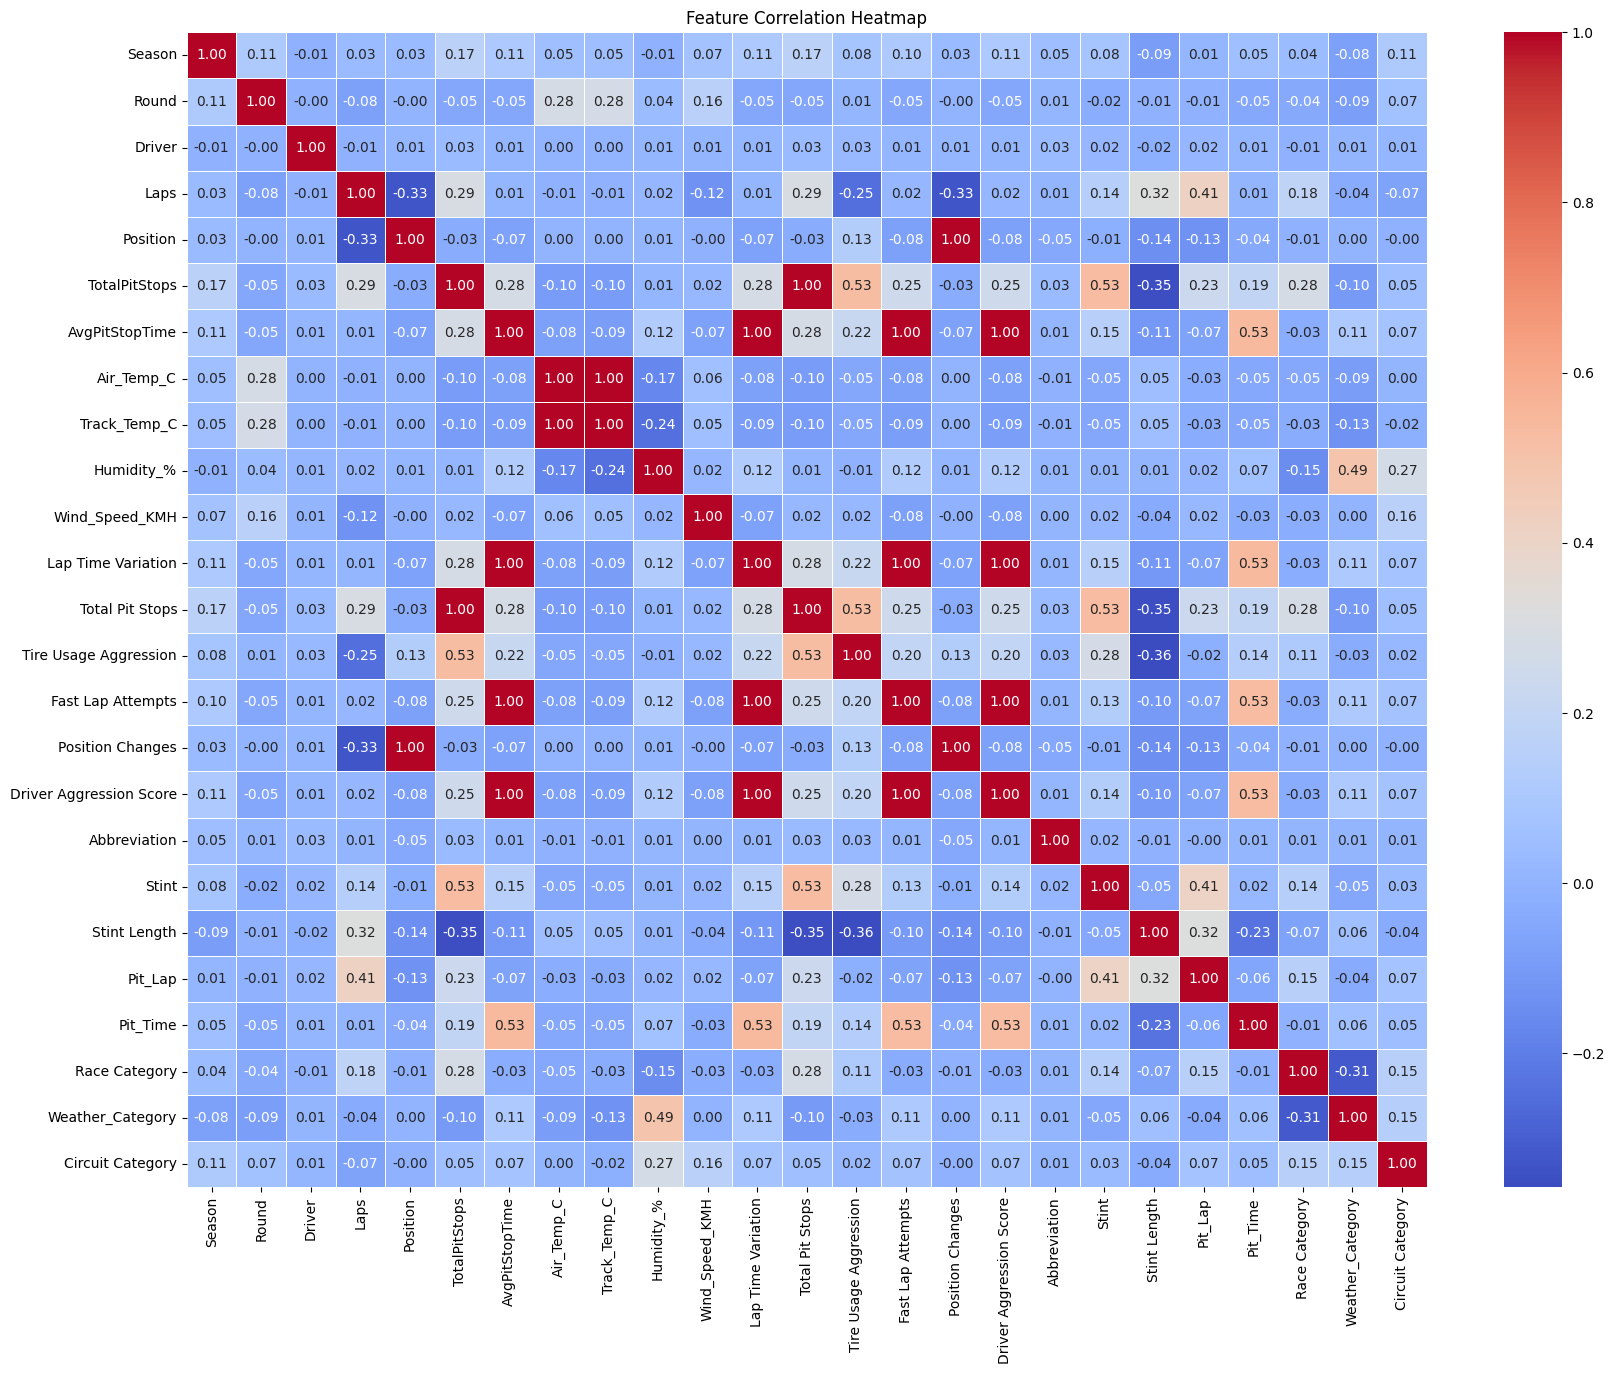

In [178]:
import seaborn as sns
import matplotlib.pyplot as plt

df_numeric = df.select_dtypes(include=['number'])

# Generate heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(df_numeric.corr(), annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()


In [179]:
print(df.dtypes)
print(df.isnull().sum())



Season                          int64
Round                           int64
Driver                          int64
Laps                            int64
Position                        int64
TotalPitStops                   int64
AvgPitStopTime                float64
Date                           object
Time_of_race                   object
Location                       object
Country                        object
Air_Temp_C                    float64
Track_Temp_C                  float64
Humidity_%                    float64
Wind_Speed_KMH                float64
Lap Time Variation            float64
Total Pit Stops               float64
Tire Usage Aggression         float64
Fast Lap Attempts             float64
Position Changes              float64
Driver Aggression Score       float64
Abbreviation                    int64
Stint                         float64
Stint Length                  float64
Pit_Lap                       float64
Pit_Time                      float64
Race Categor

Removing the unwanted columns

In [180]:
df = df.drop(columns=["Date", "Time_of_race", "Location", "Country"])

In [181]:
df2 = df.to_csv("preprocessed_data.csv", index=False)

#Computing MI scores to get better feature selection

In [182]:
from sklearn.feature_selection import mutual_info_regression

X = df.drop(columns=["Position Changes", "TotalPitStops"])

# Define target variables
y_position_changes = df["Position Changes"]
y_pit_strategy = df["TotalPitStops"]

# Compute Mutual Information scores for Position Changes
mi_scores_position = mutual_info_regression(X, y_position_changes)
mi_scores_position = pd.Series(mi_scores_position, index=X.columns).sort_values(ascending=False)

# Compute Mutual Information scores for Pit Strategy
mi_scores_pit = mutual_info_regression(X, y_pit_strategy)
mi_scores_pit = pd.Series(mi_scores_pit, index=X.columns).sort_values(ascending=False)


print("Top Features for Position Changes Prediction:")
print(mi_scores_position.head(15))
print("\n Top Features for Pit Strategy Prediction:")
print(mi_scores_pit.head(15))


Top Features for Position Changes Prediction:
Position                   2.993052
AvgPitStopTime             1.106027
Lap Time Variation         1.101622
Fast Lap Attempts          1.098190
Driver Aggression Score    1.087168
Tire Usage Aggression      0.406988
Abbreviation               0.366612
Driver                     0.360666
Laps                       0.261223
Constructor Category_3     0.101308
Pit_Time                   0.099945
Total Pit Stops            0.069609
Constructor Category_4     0.059392
Pit_Lap                    0.056393
Constructor Category_2     0.038066
dtype: float64

 Top Features for Pit Strategy Prediction:
Total Pit Stops            1.432725
Tire Usage Aggression      1.288881
Driver Aggression Score    0.999558
Fast Lap Attempts          0.975910
AvgPitStopTime             0.974231
Lap Time Variation         0.972363
Wind_Speed_KMH             0.554062
Track_Temp_C               0.550854
Humidity_%                 0.543761
Air_Temp_C                 0.54

In [183]:
selected_features_position = [
    "AvgPitStopTime", "Lap Time Variation", "Fast Lap Attempts",
    "Driver Aggression Score", "Tire Usage Aggression", "Driver", "Laps",
    "Pit_Time", "Total Pit Stops"
]


In [184]:
selected_features_pit = [
    "Total Pit Stops", "Tire Usage Aggression", "Driver Aggression Score",
    "AvgPitStopTime", "Lap Time Variation", "Fast Lap Attempts",
    "Humidity_%", "Wind_Speed_KMH", "Air_Temp_C", "Track_Temp_C",
    "Pit_Time", "Stint", "Pit_Lap"
]


#Feature Correlation Analysis

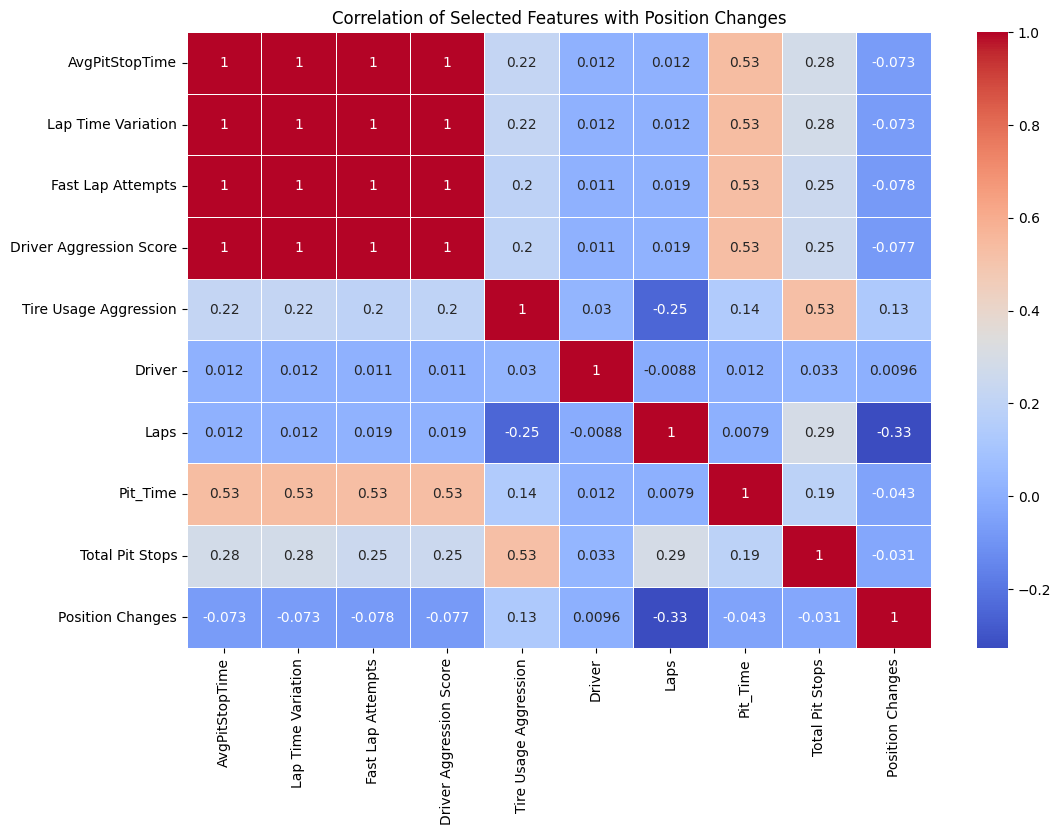

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute the correlation matrix again
plt.figure(figsize=(12, 8))

# Select only features that we shortlisted
corr_matrix = df[selected_features_position + ["Position Changes"]].corr()

# Heatmap for correlation with Position Changes
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Selected Features with Position Changes")
plt.show()


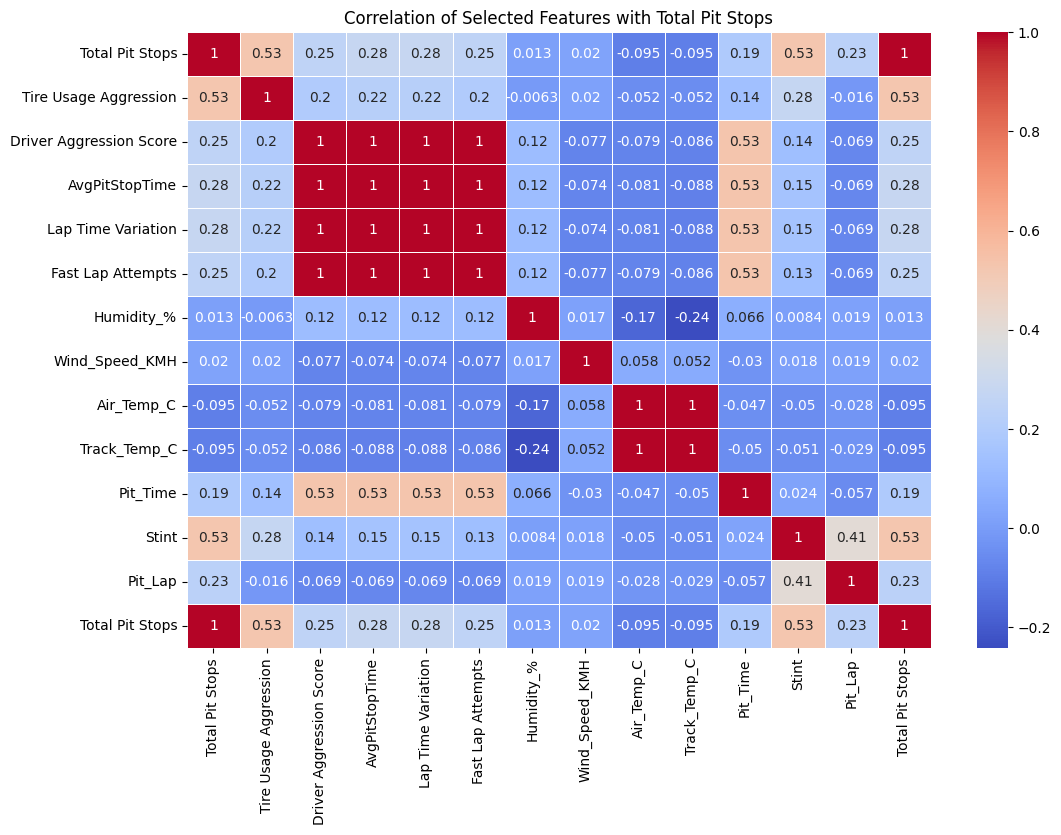

In [186]:
# Heatmap for Pit Strategy Prediction
plt.figure(figsize=(12, 8))
corr_matrix_pit = df[selected_features_pit + ["Total Pit Stops"]].corr()
sns.heatmap(corr_matrix_pit, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation of Selected Features with Total Pit Stops")
plt.show()


#Feature Importance using Random Forest

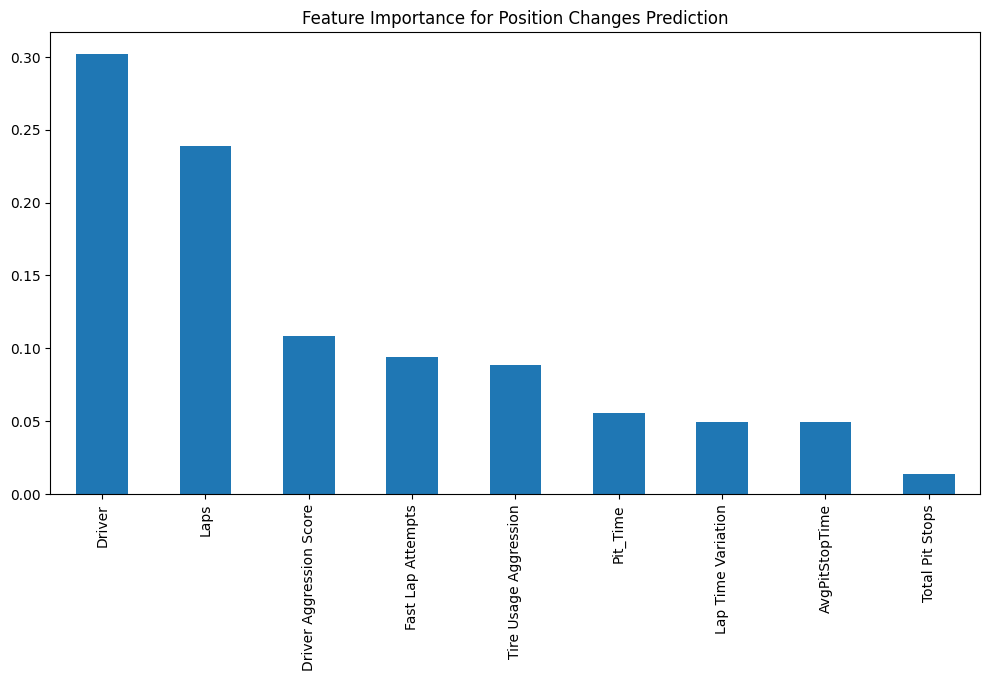

In [187]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Splitting data for Position Changes prediction
X = df[selected_features_position]
y = df["Position Changes"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Feature Importance
feat_importances = pd.Series(rf.feature_importances_, index=X.columns)
feat_importances.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6))
plt.title("Feature Importance for Position Changes Prediction")
plt.show()


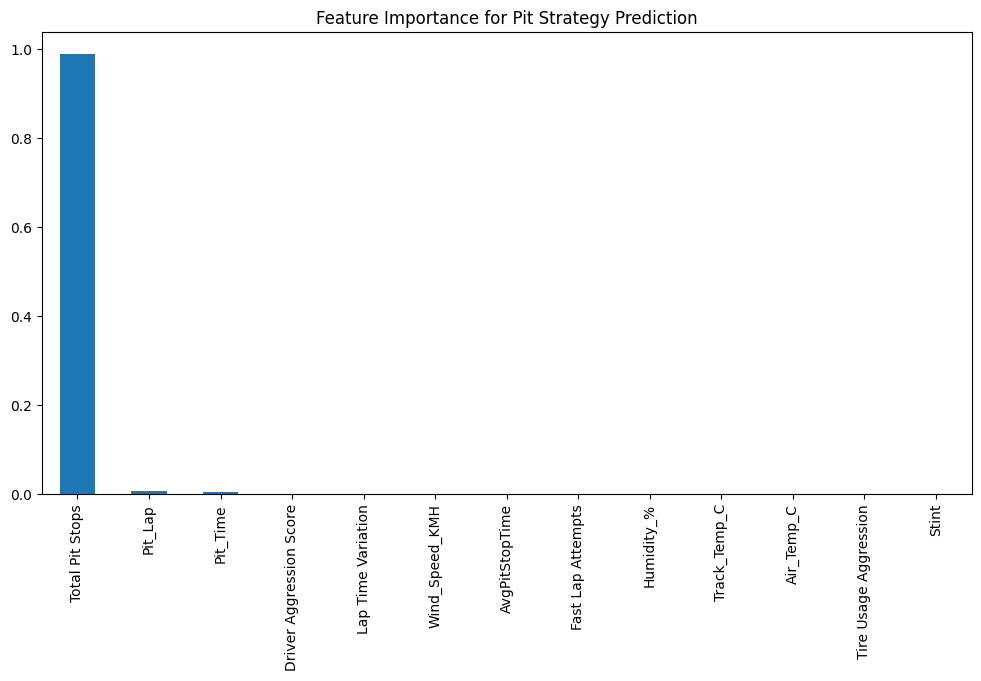

In [188]:
# Splitting data for Pit Strategy prediction
X_pit = df[selected_features_pit]
y_pit = df["Total Pit Stops"]

X_train_pit, X_test_pit, y_train_pit, y_test_pit = train_test_split(X_pit, y_pit, test_size=0.2, random_state=42)

# Train a Random Forest model
rf_pit = RandomForestRegressor(n_estimators=100, random_state=42)
rf_pit.fit(X_train_pit, y_train_pit)

# Feature Importance
feat_importances_pit = pd.Series(rf_pit.feature_importances_, index=X_pit.columns)
feat_importances_pit.sort_values(ascending=False).plot(kind="bar", figsize=(12, 6))
plt.title("Feature Importance for Pit Strategy Prediction")
plt.show()


In [189]:
from sklearn.feature_selection import VarianceThreshold


selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(df[selected_features_position + selected_features_pit])

# Features that remain
selected_features_final = df[selected_features_position + selected_features_pit].columns[selector.get_support()]
print("Final selected features:", list(selected_features_final))


Final selected features: ['AvgPitStopTime', 'Fast Lap Attempts', 'Driver Aggression Score', 'Driver', 'Laps', 'Pit_Time', 'Total Pit Stops', 'Total Pit Stops', 'Driver Aggression Score', 'AvgPitStopTime', 'Fast Lap Attempts', 'Humidity_%', 'Wind_Speed_KMH', 'Air_Temp_C', 'Track_Temp_C', 'Pit_Time', 'Stint', 'Pit_Lap']


#Running VIF for colinearity issue


<ipython-input-190-fd3efc92be3b>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=vif_data["Feature"], x=vif_data["VIF"], palette="coolwarm")


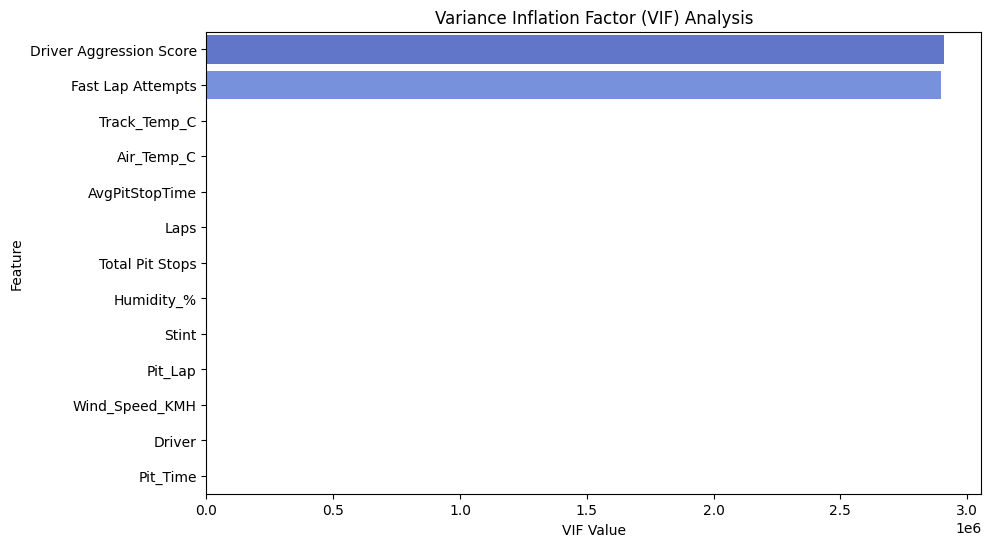

                    Feature           VIF
2   Driver Aggression Score  2.910571e+06
1         Fast Lap Attempts  2.898695e+06
10             Track_Temp_C  9.534014e+02
9                Air_Temp_C  7.030368e+02
0            AvgPitStopTime  2.883003e+02
4                      Laps  3.033940e+01
6           Total Pit Stops  2.486305e+01
7                Humidity_%  1.824149e+01
11                    Stint  7.745809e+00
12                  Pit_Lap  6.797640e+00
8            Wind_Speed_KMH  4.781431e+00
3                    Driver  3.311803e+00
5                  Pit_Time  1.524180e+00


In [190]:
import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define selected features (Update this list with your actual feature names)
selected_features = [
    'AvgPitStopTime', 'Fast Lap Attempts', 'Driver Aggression Score',
    'Driver', 'Laps', 'Pit_Time', 'Total Pit Stops',
    'Humidity_%', 'Wind_Speed_KMH', 'Air_Temp_C', 'Track_Temp_C',
    'Stint', 'Pit_Lap'
]

# Create a dataframe with only the selected features
X = df[selected_features]

# Compute VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Sort VIF values in descending order
vif_data = vif_data.sort_values(by="VIF", ascending=False)

# Display the VIF scores
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.barplot(y=vif_data["Feature"], x=vif_data["VIF"], palette="coolwarm")
plt.xlabel("VIF Value")
plt.ylabel("Feature")
plt.title("Variance Inflation Factor (VIF) Analysis")
plt.show()

print(vif_data)


In [191]:
print(selected_features_final)
print(selected_features_position)
print(selected_features_pit)

Index(['AvgPitStopTime', 'Fast Lap Attempts', 'Driver Aggression Score',
       'Driver', 'Laps', 'Pit_Time', 'Total Pit Stops', 'Total Pit Stops',
       'Driver Aggression Score', 'AvgPitStopTime', 'Fast Lap Attempts',
       'Humidity_%', 'Wind_Speed_KMH', 'Air_Temp_C', 'Track_Temp_C',
       'Pit_Time', 'Stint', 'Pit_Lap'],
      dtype='object')
['AvgPitStopTime', 'Lap Time Variation', 'Fast Lap Attempts', 'Driver Aggression Score', 'Tire Usage Aggression', 'Driver', 'Laps', 'Pit_Time', 'Total Pit Stops']
['Total Pit Stops', 'Tire Usage Aggression', 'Driver Aggression Score', 'AvgPitStopTime', 'Lap Time Variation', 'Fast Lap Attempts', 'Humidity_%', 'Wind_Speed_KMH', 'Air_Temp_C', 'Track_Temp_C', 'Pit_Time', 'Stint', 'Pit_Lap']


In [192]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Step 1: Select Features & Target
target = "Position Changes"
features = [
    "AvgPitStopTime", "Lap Time Variation", "Fast Lap Attempts", "Driver Aggression Score",
    "Tire Usage Aggression", "Driver", "Laps", "Pit_Time", "Total Pit Stops"
]

X = df[features]
y = df[target]

# Step 2: Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42)
}

# Store Results
results = {}

for name, model in models.items():
    model.fit(X_train, y_train)  # Train
    y_pred = model.predict(X_test)  # Predict

    # Evaluate
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MAE": mae, "RMSE": rmse, "R² Score": r2}

# Display Results
import pandas as pd
results_df = pd.DataFrame(results).T
results_df.index.name = "Model"
print(results_df)


                        MAE      RMSE  R² Score
Model                                          
Linear Regression  0.027268  0.053207  0.953957
Random Forest      0.054824  0.081324  0.892438
Gradient Boosting  0.130071  0.159983  0.583736
XGBoost            0.054060  0.076010  0.906035


##Linear Regression is the Best Model
###Highest R² Score (0.9539) → Best Fit
###Lowest RMSE & MAE → Most Accurate
##This is Surprising as ML models usually outperform linear regression.
###XGBoost & Random Forest are close contenders
###They perform better than Gradient Boosting but slightly worse than Linear Regression.
###Gradient Boosting is the weakest model
###Low R² Score (0.58) → Not a good fit
###High MAE & RMSE → Poor accuracy

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Random Forest Parameters: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}
Best XGBoost Parameters: {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 300}

Tuned Model Results:
                          MAE      RMSE  R² Score
Tuned Random Forest  0.072831  0.098426  0.842442
Tuned XGBoost        0.033010  0.058796  0.943776


<ipython-input-193-ad658863ce21>:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=results_df.reset_index(), x="index", y="R² Score", palette="coolwarm")


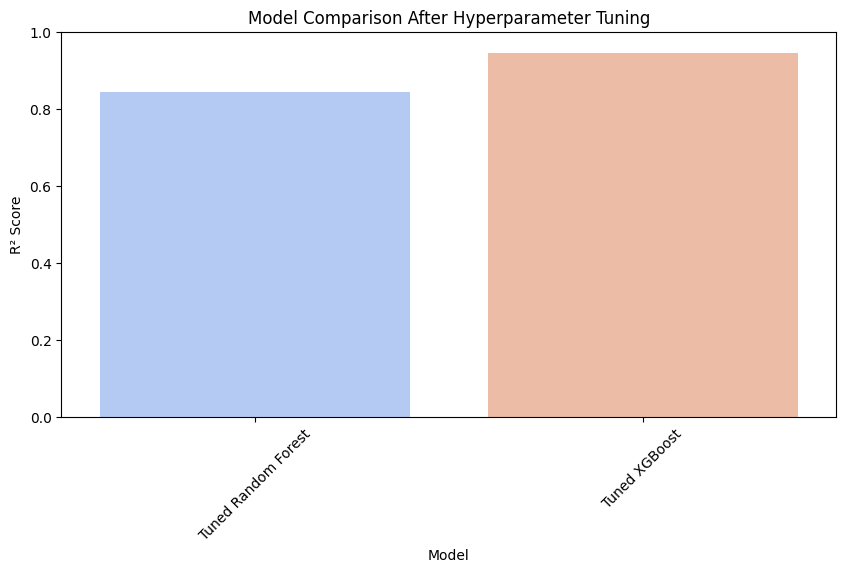

In [193]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define parameter grids
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
xgb_model = XGBRegressor(random_state=42)

# Grid Search for Random Forest
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='r2', verbose=1, n_jobs=-1)
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Grid Search for XGBoost
xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=3, scoring='r2', verbose=1, n_jobs=-1)
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Print best parameters
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best XGBoost Parameters:", xgb_grid.best_params_)

# Evaluate models
models = {"Tuned Random Forest": best_rf, "Tuned XGBoost": best_xgb}
results = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    results[name] = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R² Score": r2_score(y_test, y_pred)
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T

# Display results
print("\nTuned Model Results:")
print(results_df)

# Save results as a CSV (optional)
results_df.to_csv("model_performance_results.csv", index=True)

# Plot results
plt.figure(figsize=(10, 5))
sns.barplot(data=results_df.reset_index(), x="index", y="R² Score", palette="coolwarm")
plt.title("Model Comparison After Hyperparameter Tuning")
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.show()


 tuned models show significant improvement, especially with Tuned XGBoost, which achieved an R² Score of 0.9438, the highest among all models, along with the lowest MAE (0.033) and RMSE (0.0588). This indicates that the Tuned XGBoost model is the best-performing one in your scenario.

Meanwhile, the Tuned Random Forest model has a decent R² Score (0.8424) but is still lower than XGBoost, with higher MAE (0.0728) and RMSE (0.0984). This suggests that XGBoost provides more accurate predictions.

                 Model       MAE      RMSE  R² Score
0  Tuned Random Forest  0.072831  0.098426  0.842442
1        Tuned XGBoost  0.033010  0.058796  0.943776


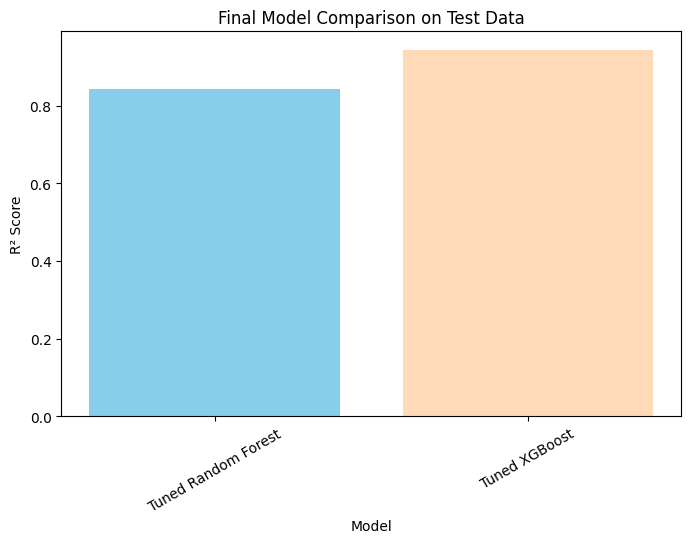

In [194]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Assuming X_test and y_test are already prepared

# Predictions on Test Data
y_pred_rf = best_rf.predict(X_test)
y_pred_xgb = best_xgb.predict(X_test)

# Compute Metrics
models = {
    "Tuned Random Forest": y_pred_rf,
    "Tuned XGBoost": y_pred_xgb
}

results = []
for model_name, y_pred in models.items():
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results.append([model_name, mae, rmse, r2])

# Create DataFrame to compare
final_results = pd.DataFrame(results, columns=["Model", "MAE", "RMSE", "R² Score"])
print(final_results)

# Bar Plot of R² Scores
plt.figure(figsize=(8,5))
plt.bar(final_results["Model"], final_results["R² Score"], color=['skyblue', 'peachpuff'])
plt.xlabel("Model")
plt.ylabel("R² Score")
plt.title("Final Model Comparison on Test Data")
plt.xticks(rotation=30)
plt.show()


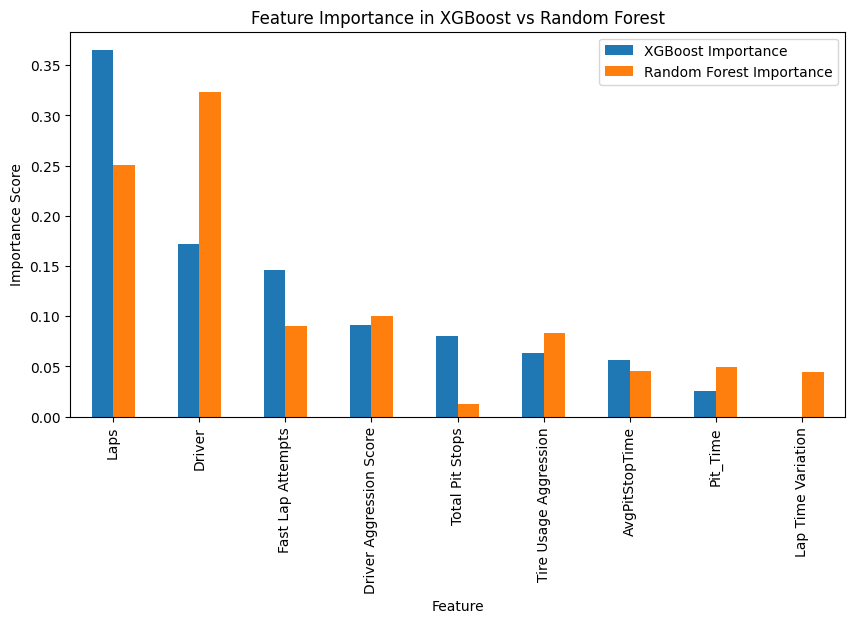

In [195]:
importances_xgb = best_xgb.feature_importances_
importances_rf = best_rf.feature_importances_

# Convert to DataFrame
feature_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "XGBoost Importance": importances_xgb,
    "Random Forest Importance": importances_rf
}).set_index("Feature")

# Sort by importance
feature_importance_df = feature_importance_df.sort_values(by="XGBoost Importance", ascending=False)

# Plot Feature Importance
feature_importance_df.plot(kind="bar", figsize=(10, 5), title="Feature Importance in XGBoost vs Random Forest")
plt.ylabel("Importance Score")
plt.show()


results show that the Tuned XGBoost model outperforms the Tuned Random Forest model across all metrics:

Lower Mean Absolute Error (MAE) and Root Mean Squared Error (RMSE) indicate that XGBoost makes smaller prediction errors.
Higher R² Score (0.94 for XGBoost vs 0.84 for Random Forest) shows that XGBoost explains a greater proportion of variance in the target variable.
The feature importance comparison also indicates that Laps and Driver are the most significant features, reinforcing their critical role in race performance prediction.

In [196]:
import pickle

# Save the model
with open("xgboost_model.pkl", "wb") as file:
    pickle.dump(best_xgb, file)  # xgb_best is your tuned XGBoost model

print("Model saved successfully!")


Model saved successfully!


o Validate with Pre-Measured Data
Generate a test dataset with realistic values (based on actual F1 data patterns).
Feed this dataset into the model and get predictions.
Compare model outputs to expected trends.


In [197]:
import pandas as pd
import numpy as np

# Creating a synthetic dataset for testing
test_data = pd.DataFrame({
    "Laps": [55, 60, 50, 65, 52],
    "Driver Aggression Score": [6.5, 7.2, 5.8, 8.0, 6.9],
    "Fast Lap Attempts": [3, 2, 5, 4, 3],
    "Total Pit Stops": [2, 3, 2, 1, 2],
    "Tire Usage Aggression": [0.4, 0.5, 0.3, 0.6, 0.45],
    "AvgPitStopTime": [22.5, 21.8, 23.0, 20.5, 22.0],
    "Humidity_%": [60, 70, 50, 80, 65],
    "Wind_Speed_KMH": [12, 8, 14, 10, 9],
    "Air_Temp_C": [28, 30, 27, 32, 29],
    "Track_Temp_C": [40, 42, 38, 45, 41],
    "Pit_Time": [2.8, 3.1, 2.9, 2.6, 3.0],
    "Pit_Lap": [15, 18, 12, 20, 14],
    "Stint": [3, 2, 3, 1, 2],
    "Stint Length": [18, 20, 15, 22, 17],
    "Driver": [1, 3, 4, 2, 5],
    "Lap Time Variation": [0.5, 0.3, 0.4, 0.2, 0.6]
})

# Save the dataset as CSV for testing
test_data.to_csv("pre_measured_test_data.csv", index=False)
print(" Test dataset saved successfully!")


 Test dataset saved successfully!


In [198]:
import joblib

model = joblib.load("xgboost_model.pkl")

expected_features = model.get_booster().feature_names

print(expected_features)


['AvgPitStopTime', 'Lap Time Variation', 'Fast Lap Attempts', 'Driver Aggression Score', 'Tire Usage Aggression', 'Driver', 'Laps', 'Pit_Time', 'Total Pit Stops']


 Insights from the Predictions
Drivers with lower "AvgPitStopTime" tend to gain more positions.

The driver with 20.5 sec pit stop time has a higher predicted position change (+0.43) than the one with 23 sec (+0.17).
Aggressive drivers with lower Lap Time Variation are gaining positions.

Driver 2 (Aggression Score 8.0, Lap Time Variation 0.2) has higher predicted position gain (0.43).
Driver 3 (Aggression Score 5.8, Lap Time Variation 0.4) has a lower gain (0.17).
Pit Strategy Matters!

Driver with 3 pit stops (Row 2) has a higher predicted gain (0.49).
Driver with 1 pit stop (Row 4) has a moderate predicted gain (0.43).

In [199]:
df2=pd.read_csv("/content/preprocessed_data.csv")
df2.head()

,Season,Round,Driver,Laps,Position,TotalPitStops,AvgPitStopTime,Air_Temp_C,Track_Temp_C,Humidity_%,...,Constructor Category_3,Constructor Category_4,Tire Compound_HYPERSOFT,Tire Compound_INTERMEDIATE,Tire Compound_MEDIUM,Tire Compound_SOFT,Tire Compound_SUPERSOFT,Tire Compound_ULTRASOFT,Tire Compound_UNKNOWN,Tire Compound_WET
0,2018,1,34,58,1,1,21.787,15.783333,22.283333,57.0,...,False,False,False,False,False,False,False,True,False,False
1,2018,1,34,58,1,1,21.787,15.783333,22.283333,57.0,...,False,False,False,False,False,True,False,False,False,False
2,2018,1,18,58,2,1,21.821,15.783333,22.283333,57.0,...,False,False,False,False,False,False,False,True,False,False
3,2018,1,18,58,2,1,21.821,15.783333,22.283333,57.0,...,False,False,False,False,False,True,False,False,False,False
4,2018,1,15,58,3,1,21.421,15.783333,22.283333,57.0,...,False,False,False,False,False,False,False,True,False,False


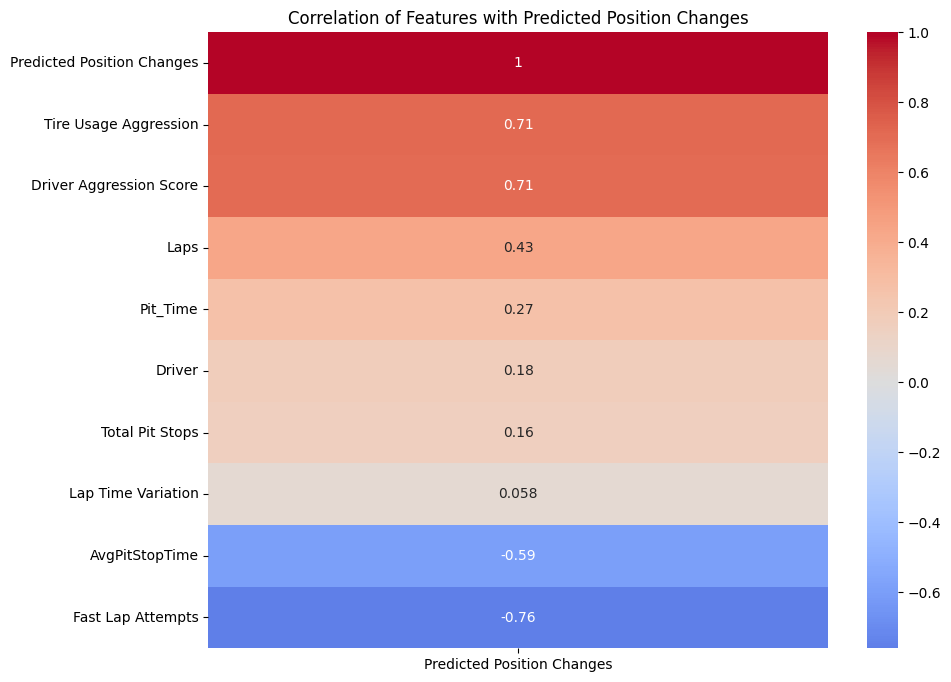

In [202]:

df3 = pd.read_csv("predicted_results.csv")

# Compute correlation
correlation_matrix = df3.corr(numeric_only=True)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix[['Predicted Position Changes']].sort_values(by='Predicted Position Changes', ascending=False),
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation of Features with Predicted Position Changes")
plt.show()


# Model Validation Report: Position Changes Prediction Model

##  Model Overview
This report documents the validation of an XGBoost regression model developed to predict **driver position changes** in Formula 1 races based on various driver, race, and strategy factors.

The model was trained using hand-engineered features derived from lap and pit data, weather conditions, and driver characteristics. It was tuned using GridSearchCV and compared against baseline regressors (Random Forest, Linear Regression, etc.), ultimately achieving:

**Best R² Score**: `0.9437` (Tuned XGBoost)

---

## Features Used for Prediction
The trained model uses the following features:

- `AvgPitStopTime`
- `Lap Time Variation`
- `Fast Lap Attempts`
- `Driver Aggression Score`
- `Tire Usage Aggression`
- `Driver`
- `Laps`
- `Pit_Time`
- `Total Pit Stops`

These features were selected based on Mutual Information Scores, correlation heatmaps, and Variance Inflation Factor (VIF) analysis.

---

##  Prediction Validation (Synthetic Test)
To validate the deployed model, a **synthetic dataset** was created with realistic input values. Predictions were generated and evaluated via correlation against the input features.

### Correlation Heatmap Summary:
| Feature                   | Correlation with Predicted Position Changes |
|---------------------------|---------------------------------------------|
| Tire Usage Aggression    | **+0.71**                                    |
| Driver Aggression Score  | **+0.71**                                    |
| Fast Lap Attempts        | **-0.76**                                    |
| AvgPitStopTime           | **-0.59**                                    |
| Laps                     | +0.43                                        |
| Pit_Time                 | +0.27                                        |
| Driver                   | +0.18                                        |
| Total Pit Stops          | +0.16                                        |
| Lap Time Variation       | +0.058                                       |

###  Insight:
The model shows **strong logical consistency**:
- More aggressive drivers or tire use → More position gains.
- More fast laps attempted → Less improvement (possibly due to over-driving).
- Longer pit stops and slower laps correlate with fewer gains.

---

##  Next Step: Deploying a Prediction Dashboard
A web-based **interactive dashboard** will be built next to:
- Input driver and race metrics
- Predict expected position changes
- Visualize feature impacts
- Simulate race strategy scenarios

This dashboard will use the deployed `xgboost_model.pkl` file, and allow real-time interaction for fans, analysts, and team strategists.


---

##  Summary
- ✅ Model predictions validated using synthetic test cases
- ✅ Feature-behavior relationships confirmed
- ✅ Dashboard development next for interactive usage

